In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [7]:
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')[['Close']]
df.columns = ['price']

window = 50
df['ma'] = df['price'].rolling(50).mean()
df['position'] = np.where(df['price'] > df['ma'], 1, -1)
df['returns'] = df['price'].pct_change()
df['strategy'] = df['position'].shift(1) * df['returns']
df.dropna(inplace=True)

C:\Users\Alqama\AppData\Local\Temp\ipykernel_956\3778674705.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-12-31')[['Close']]
[*********************100%***********************]  1 of 1 completed


In [8]:
class StrategyAnalytics:
    def __init__(self, df, return_col='strategy', risk_free_rate=0.0):
        self.df = df.copy()
        self.returns = self.df[return_col]
        self.rfr = risk_free_rate

    def total_return(self):
        return (1 + self.returns).prod() - 1

    def annualized_return(self):
        return (1 + self.total_return()) ** (252 / len(self.returns)) - 1

    def annualized_volatility(self):
        return self.returns.std() * np.sqrt(252)

    def sharpe_ratio(self):
        excess_return = self.returns - self.rfr / 252
        return excess_return.mean() / excess_return.std() * np.sqrt(252)

    def max_drawdown(self):
        cum_returns = (1 + self.returns).cumprod()
        peak = cum_returns.cummax()
        drawdown = (cum_returns - peak) / peak
        return drawdown.min()

    def calmar_ratio(self):
        dd = abs(self.max_drawdown())
        return self.annualized_return() / dd if dd != 0 else np.nan

    def summary(self):
        return {
            "Total Return (%)": round(100 * self.total_return(), 2),
            "Annualized Return (%)": round(100 * self.annualized_return(), 2),
            "Annualized Volatility (%)": round(100 * self.annualized_volatility(), 2),
            "Sharpe Ratio": round(self.sharpe_ratio(), 2),
            "Max Drawdown (%)": round(100 * self.max_drawdown(), 2),
            "Calmar Ratio": round(self.calmar_ratio(), 2)
        }


In [9]:
analytics = StrategyAnalytics(df)
summary = analytics.summary()

for k, v in summary.items():
    print(f"{k}: {v}")

Total Return (%): -1.21
Annualized Return (%): -0.25
Annualized Volatility (%): 30.62
Sharpe Ratio: 0.15
Max Drawdown (%): -53.6
Calmar Ratio: -0.0


<Axes: title={'center': 'Strategy Equity Curve'}, xlabel='Date'>

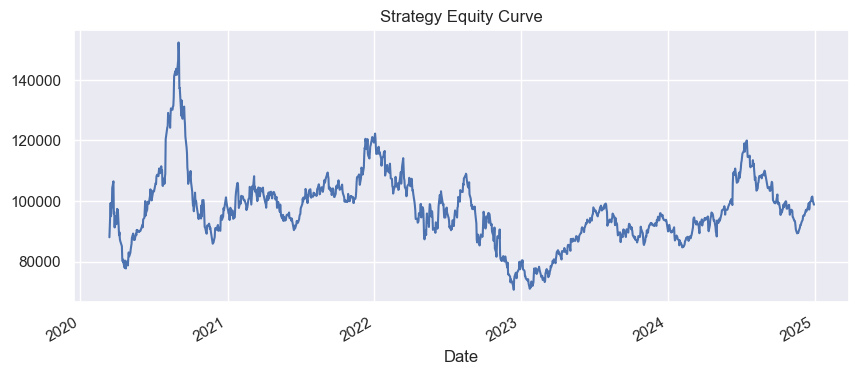

In [13]:
df['equity_curve'] = 100_000 * (1 + df['strategy']).cumprod()
df['equity_curve'].plot(figsize=(10, 4), title='Strategy Equity Curve')